In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage.metrics import structural_similarity

In [57]:
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz=0.312, Nx=64, real_dx=10, real_units='um', color='w'):
    #.235 = 150 um, 0.312= 200 um
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False, color=color)
    ax.add_artist(scalebar)
    
def get_rmse(im1, im2):
    return np.sqrt(np.mean((im1-im2)**2))

def get_ssim(im1, im2, data_range=2):
    return structural_similarity(im1, im2, data_range=data_range)

def get_metrics(im1, im2, data_range=2):
    return [get_rmse(im1, im2), get_ssim(im1, im2, data_range)]


In [3]:
outd_main = 'par1/'
figd = outd_main + 'figs/'
os.makedirs(figd, exist_ok=True)

energies = [24, 34]
propdists = [0, 50, 100]    # [mm]
best_iters = [300, 500, 1500]   # best k recon corresponding to propdist
Nx = 64
Ny = 20
Nz = 64
Na = 100
vol_shape = (Nx, Ny, Nz, 2)
lvl = 10
dens1 = 1.06
dens2 = 1.92
mat1 = 'Tissue'
mat2 = 'Bone'
mats = [mat1, mat2]
densities = [dens1, dens2]

def loadfile(fname, shape, cwd=outd_main, dtype=np.float32):
    return np.fromfile(cwd+fname, dtype=dtype).reshape(shape)

# Fig: True phantom

In [4]:
phantom = loadfile('phantom.bin', vol_shape)

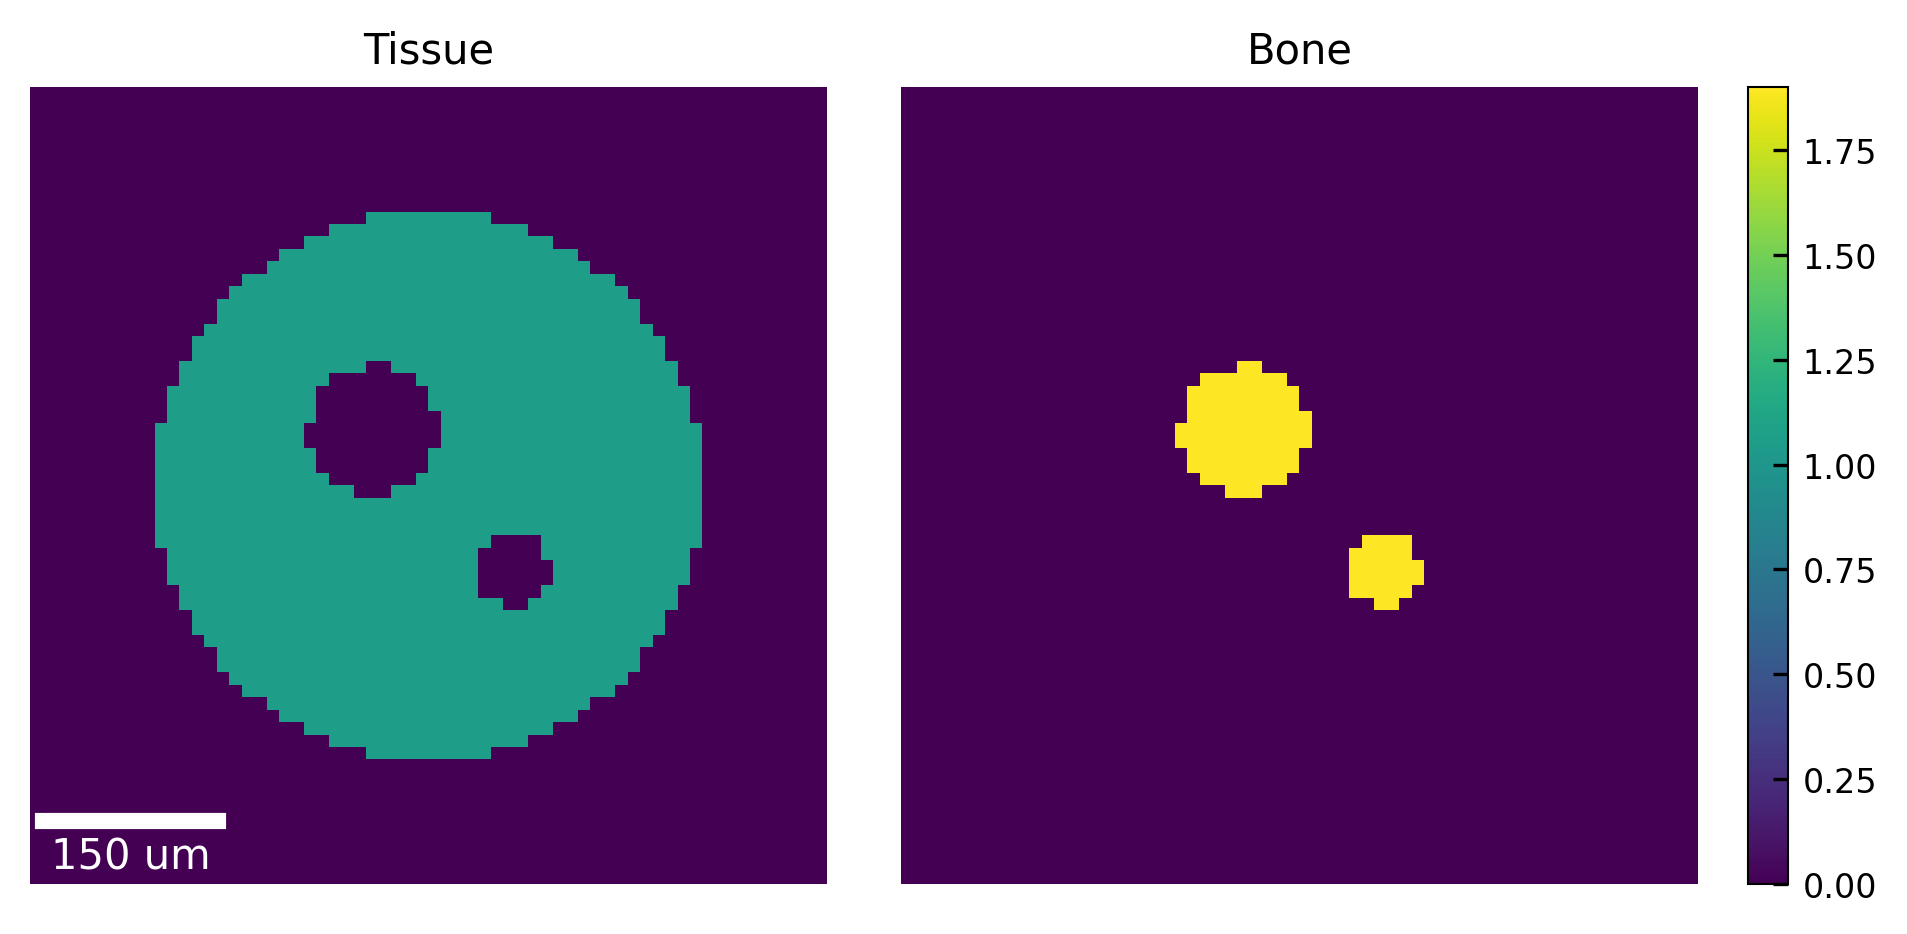

In [5]:
kw = {'cmap':'viridis','vmin':0, 'vmax':1.9}

fig, ax = plt.subplots(1, 2, figsize=[6.3,3], dpi=300, layout='constrained')

for i in range(2):
    m = ax[i].imshow(phantom[:,lvl,:,i], **kw)
    ax[i].axis('off')
    ax[i].set_title(mats[i])
fig.colorbar(m, pad=0.06)
add_scalebar(ax[0])

plt.savefig(figd+'phantom.pdf')
plt.show()
    

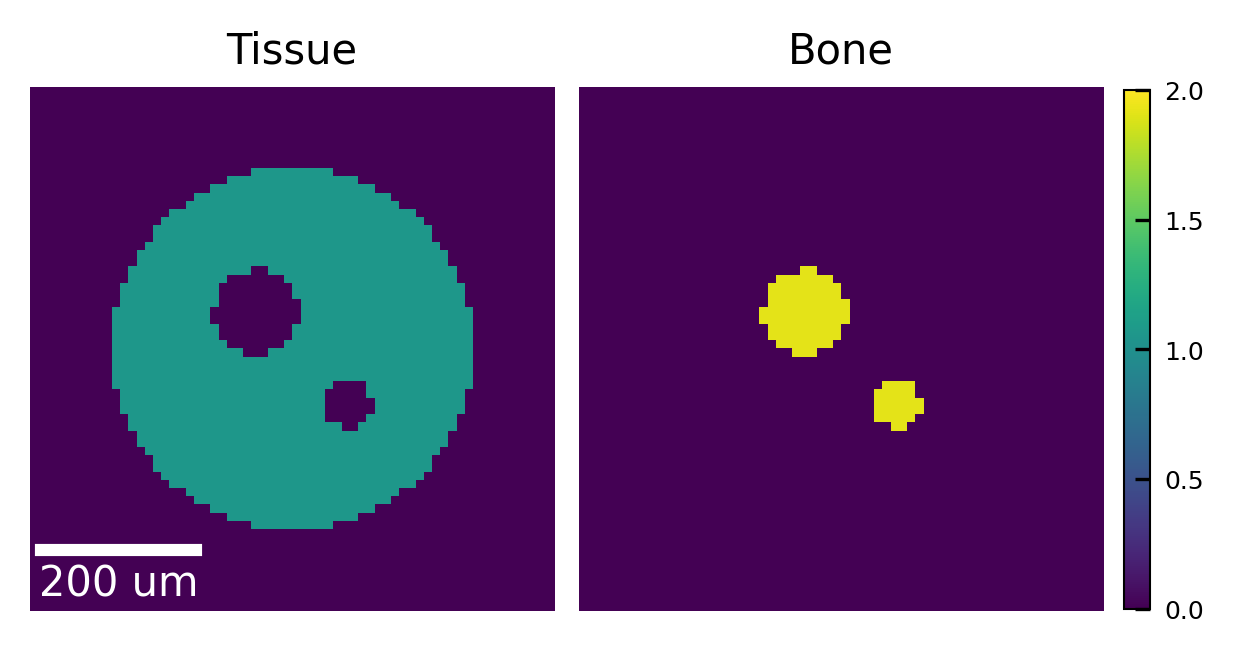

In [58]:
kw = {'cmap':'viridis','vmin':0, 'vmax':2}

fig, ax = plt.subplots(1, 2, figsize=[4,2.1], dpi=300, layout='constrained')

for i in range(2):
    m = ax[i].imshow(phantom[:,lvl,:,i], **kw)
    ax[i].axis('off')
    ax[i].set_title(mats[i])
cbar = fig.colorbar(m, pad=0.04, shrink=0.92, ticks=np.arange(0,2.1,0.5))
cbar.ax.tick_params(labelsize=6) 

add_scalebar(ax[0])#, sz=0.25)

plt.savefig(figd+'phantom_tight.pdf')
plt.show()
    

# Fig: Raw recons

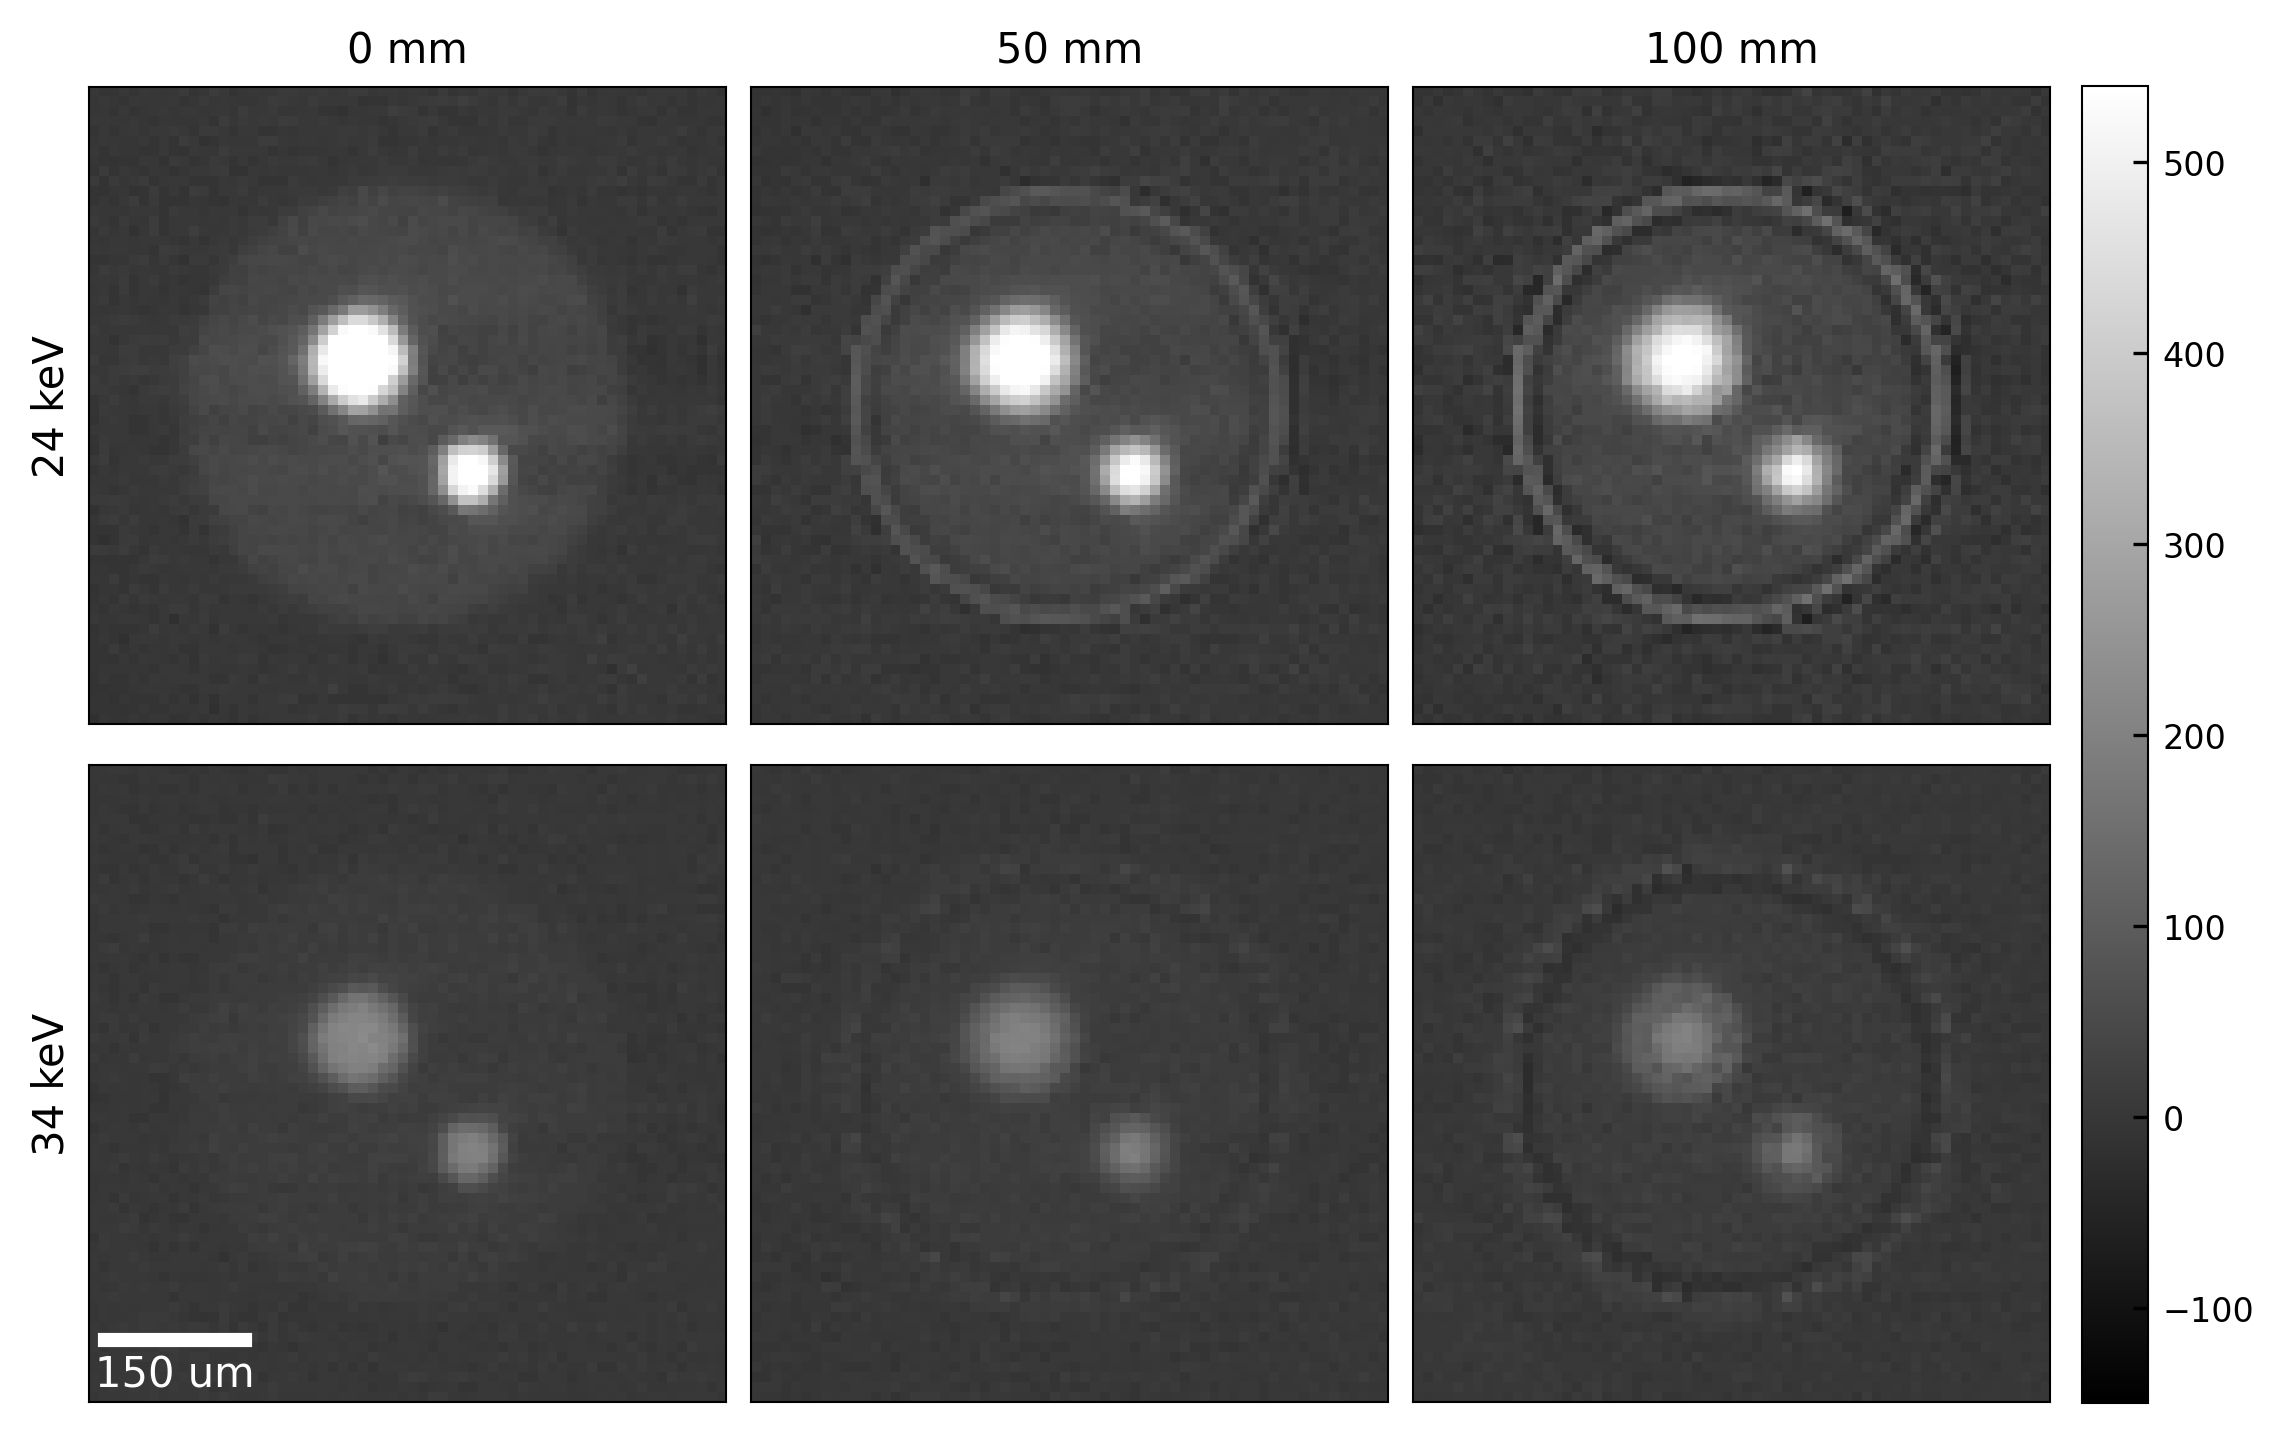

In [48]:
kw = {'vmin':-150, 'vmax':540}

fig, ax = plt.subplots(2, 3, figsize=[7.5,4.7], dpi=300, layout='constrained')

for j, propdist in enumerate(propdists):
    ax[0,j].set_title(f'{propdist:.0f} mm')
    recon = loadfile('recon.bin', vol_shape, cwd=outd_main+f'{propdist:03}mm/')[::-1,:,::-1,:]
    for i in range(2):
        m = ax[i,j].imshow(recon[:,lvl,:,i], **kw)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,0].set_ylabel(f'{energies[i]:.0f} keV', fontsize=10)
add_scalebar(ax[1,0])
fig.colorbar(m, ax=ax[:,2], shrink=0.99)

plt.savefig(figd+'recons.pdf')
plt.show()

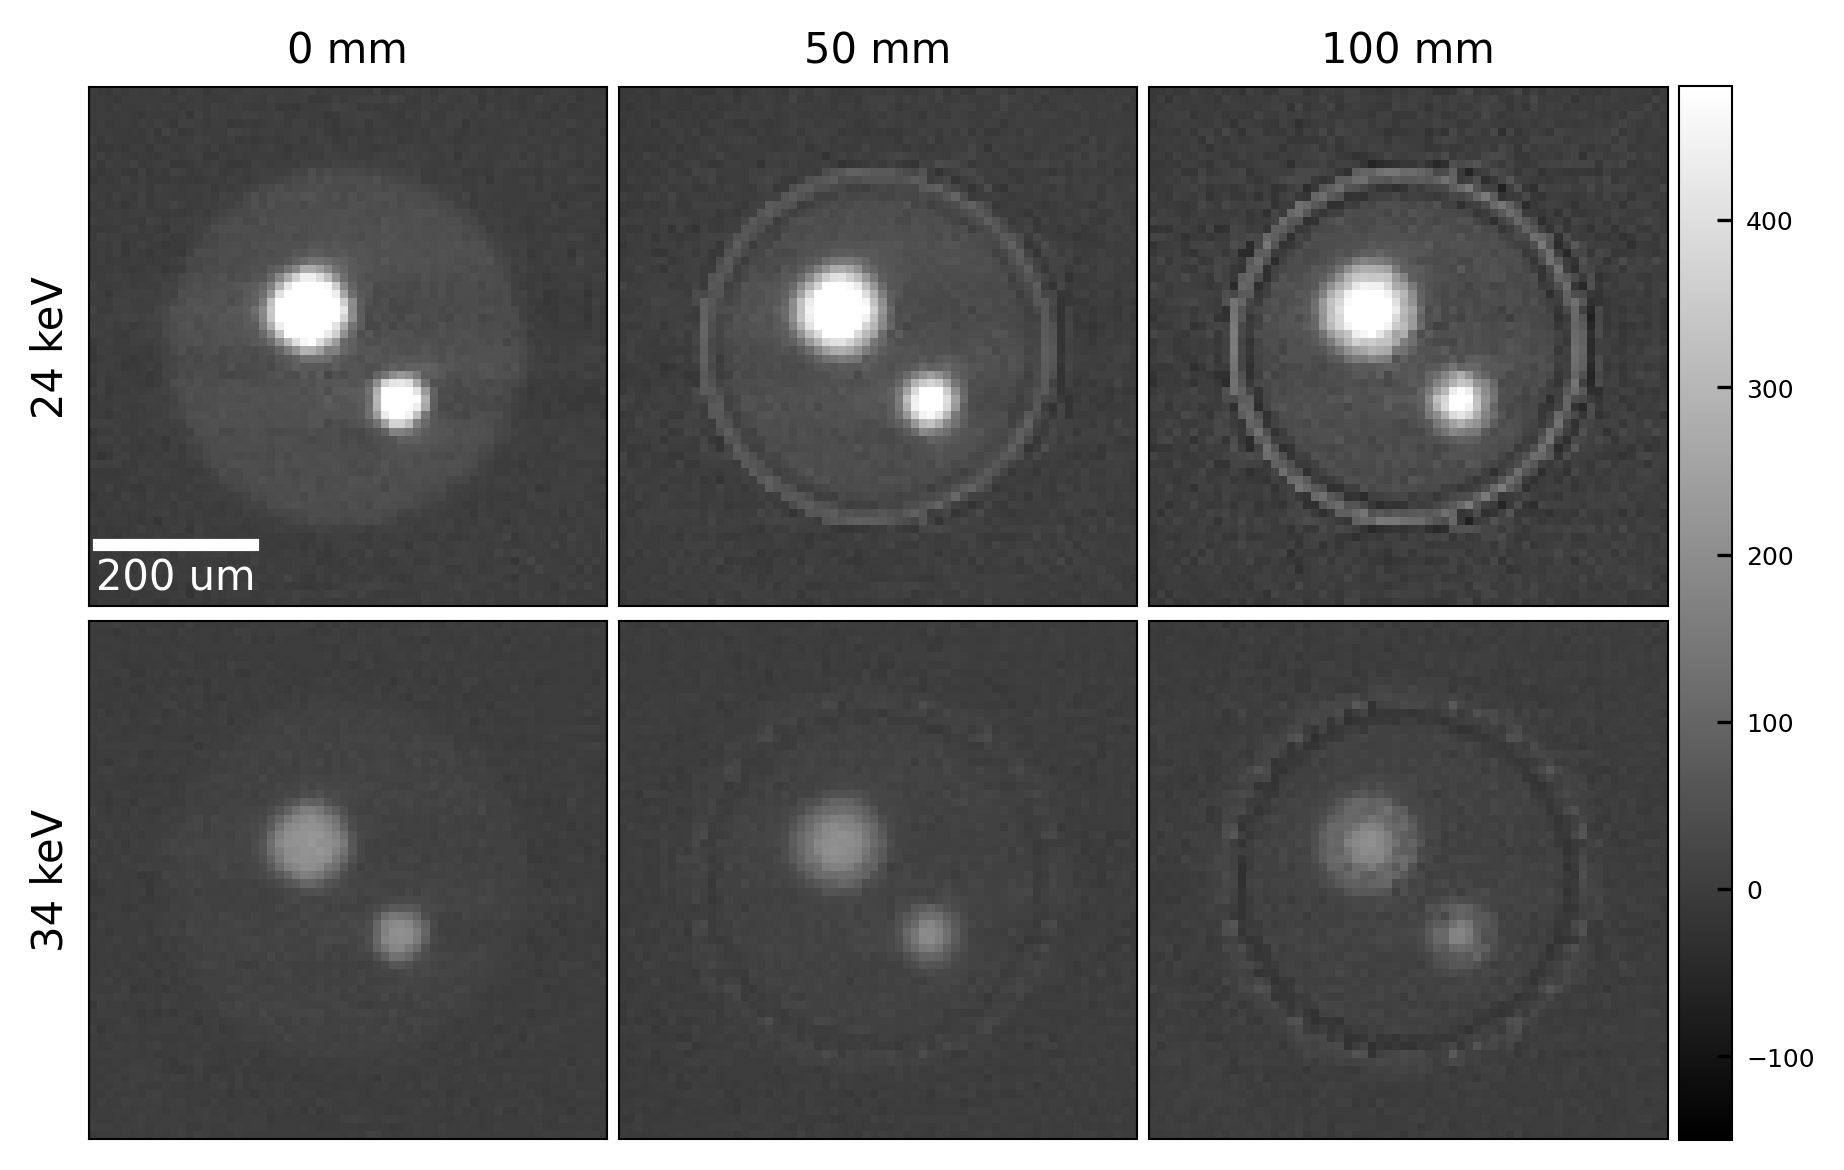

In [110]:
# kw = {'vmin':-150, 'vmax':540}
kw = {'vmin':-150, 'vmax':480}

fig, ax = plt.subplots(2, 3, figsize=[5.95,3.72], dpi=300, layout='constrained')

for j, propdist in enumerate(propdists):
    ax[0,j].set_title(f'{propdist:.0f} mm')
    recon = loadfile('recon.bin', vol_shape, cwd=outd_main+f'{propdist:03}mm/')[::-1,:,::-1,:]
    for i in range(2):
        m = ax[i,j].imshow(recon[:,lvl,:,i], **kw)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,0].set_ylabel(f'{energies[i]:.0f} keV', fontsize=10)
        # if j==0:
            
add_scalebar(ax[0,0])
cbar = fig.colorbar(m, ax=ax[:,2], pad=0.022, shrink=0.993)
cbar.ax.tick_params(labelsize=6) 
fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=.01, wspace=.02)

plt.savefig(figd+'recons_tight.pdf')
plt.show()

# Table: SSIM and RMSE

In [7]:
for imat in range(2):
    print(f'\n ***{mats[imat]}***')
    print('        & SSIM                      & RMSE                      \\\\')
    print('        & Optimization  &  TIE/FBP  & Optimization  &  TIE/FBP  \\\\')

    im_truth = phantom[:,lvl,:,imat] / densities[imat]
    for j, propdist in enumerate(propdists):
        k = best_iters[j]
        
        img_opt = loadfile(f'vol_{k:04}.bin', vol_shape, cwd=outd_main+f'{propdist:03}mm/')[:,lvl,:,imat] / densities[imat]
        rmse_opt, ssim_opt = get_metrics(img_opt, im_truth)
        
        img_tie = loadfile('vol_tie.bin', vol_shape, cwd=outd_main+f'{propdist:03}mm/')[:,lvl,:,imat] / densities[imat]
        rmse_tie, ssim_tie = get_metrics(img_tie, im_truth)

        print(f'{propdist:4} mm & {ssim_opt:12.2f}  & {ssim_tie:8.2f}  & {rmse_opt:12.2f}  & {rmse_tie:8.2f}  \\\\')


 ***Tissue***
        & SSIM                      & RMSE                      \\
        & Optimization  &  TIE/FBP  & Optimization  &  TIE/FBP  \\
   0 mm &         0.82  &     0.00  &         0.25  &     5.00  \\
  50 mm &         0.63  &     0.34  &         0.20  &     0.22  \\
 100 mm &         0.54  &     0.22  &         0.21  &     0.36  \\

 ***Bone***
        & SSIM                      & RMSE                      \\
        & Optimization  &  TIE/FBP  & Optimization  &  TIE/FBP  \\
   0 mm &         1.00  &     0.06  &         0.02  &     0.32  \\
  50 mm &         0.94  &     0.33  &         0.04  &     0.11  \\
 100 mm &         0.83  &     0.21  &         0.04  &     0.17  \\


# Fig: Basis material decomposition

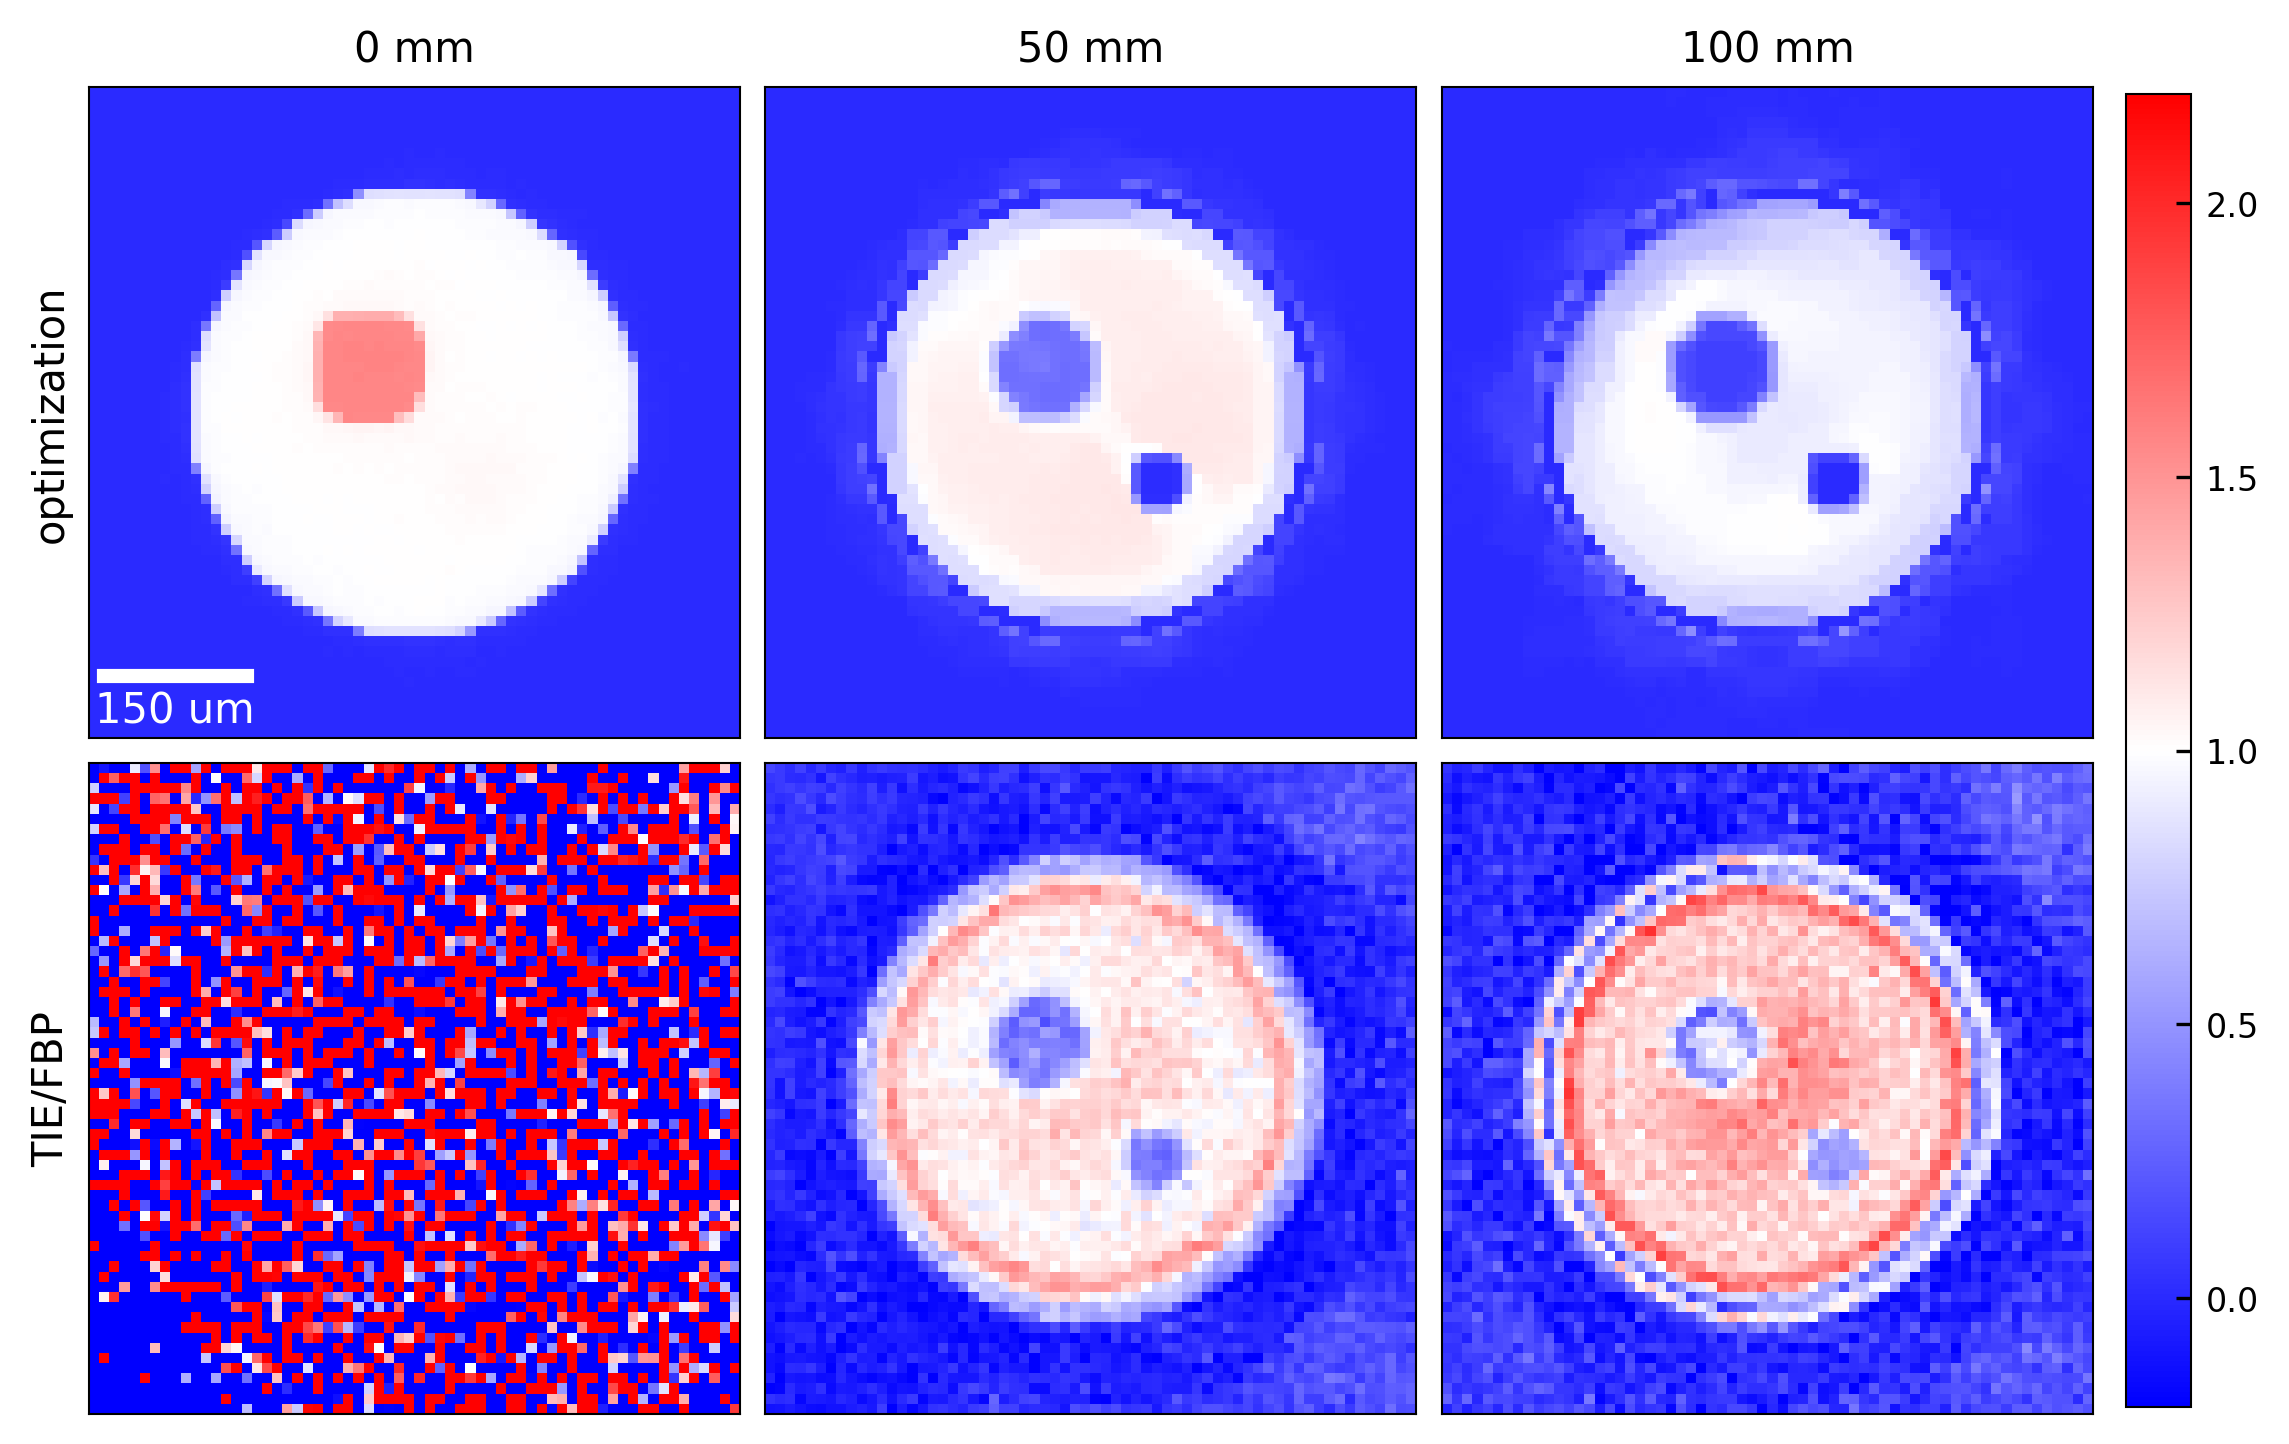

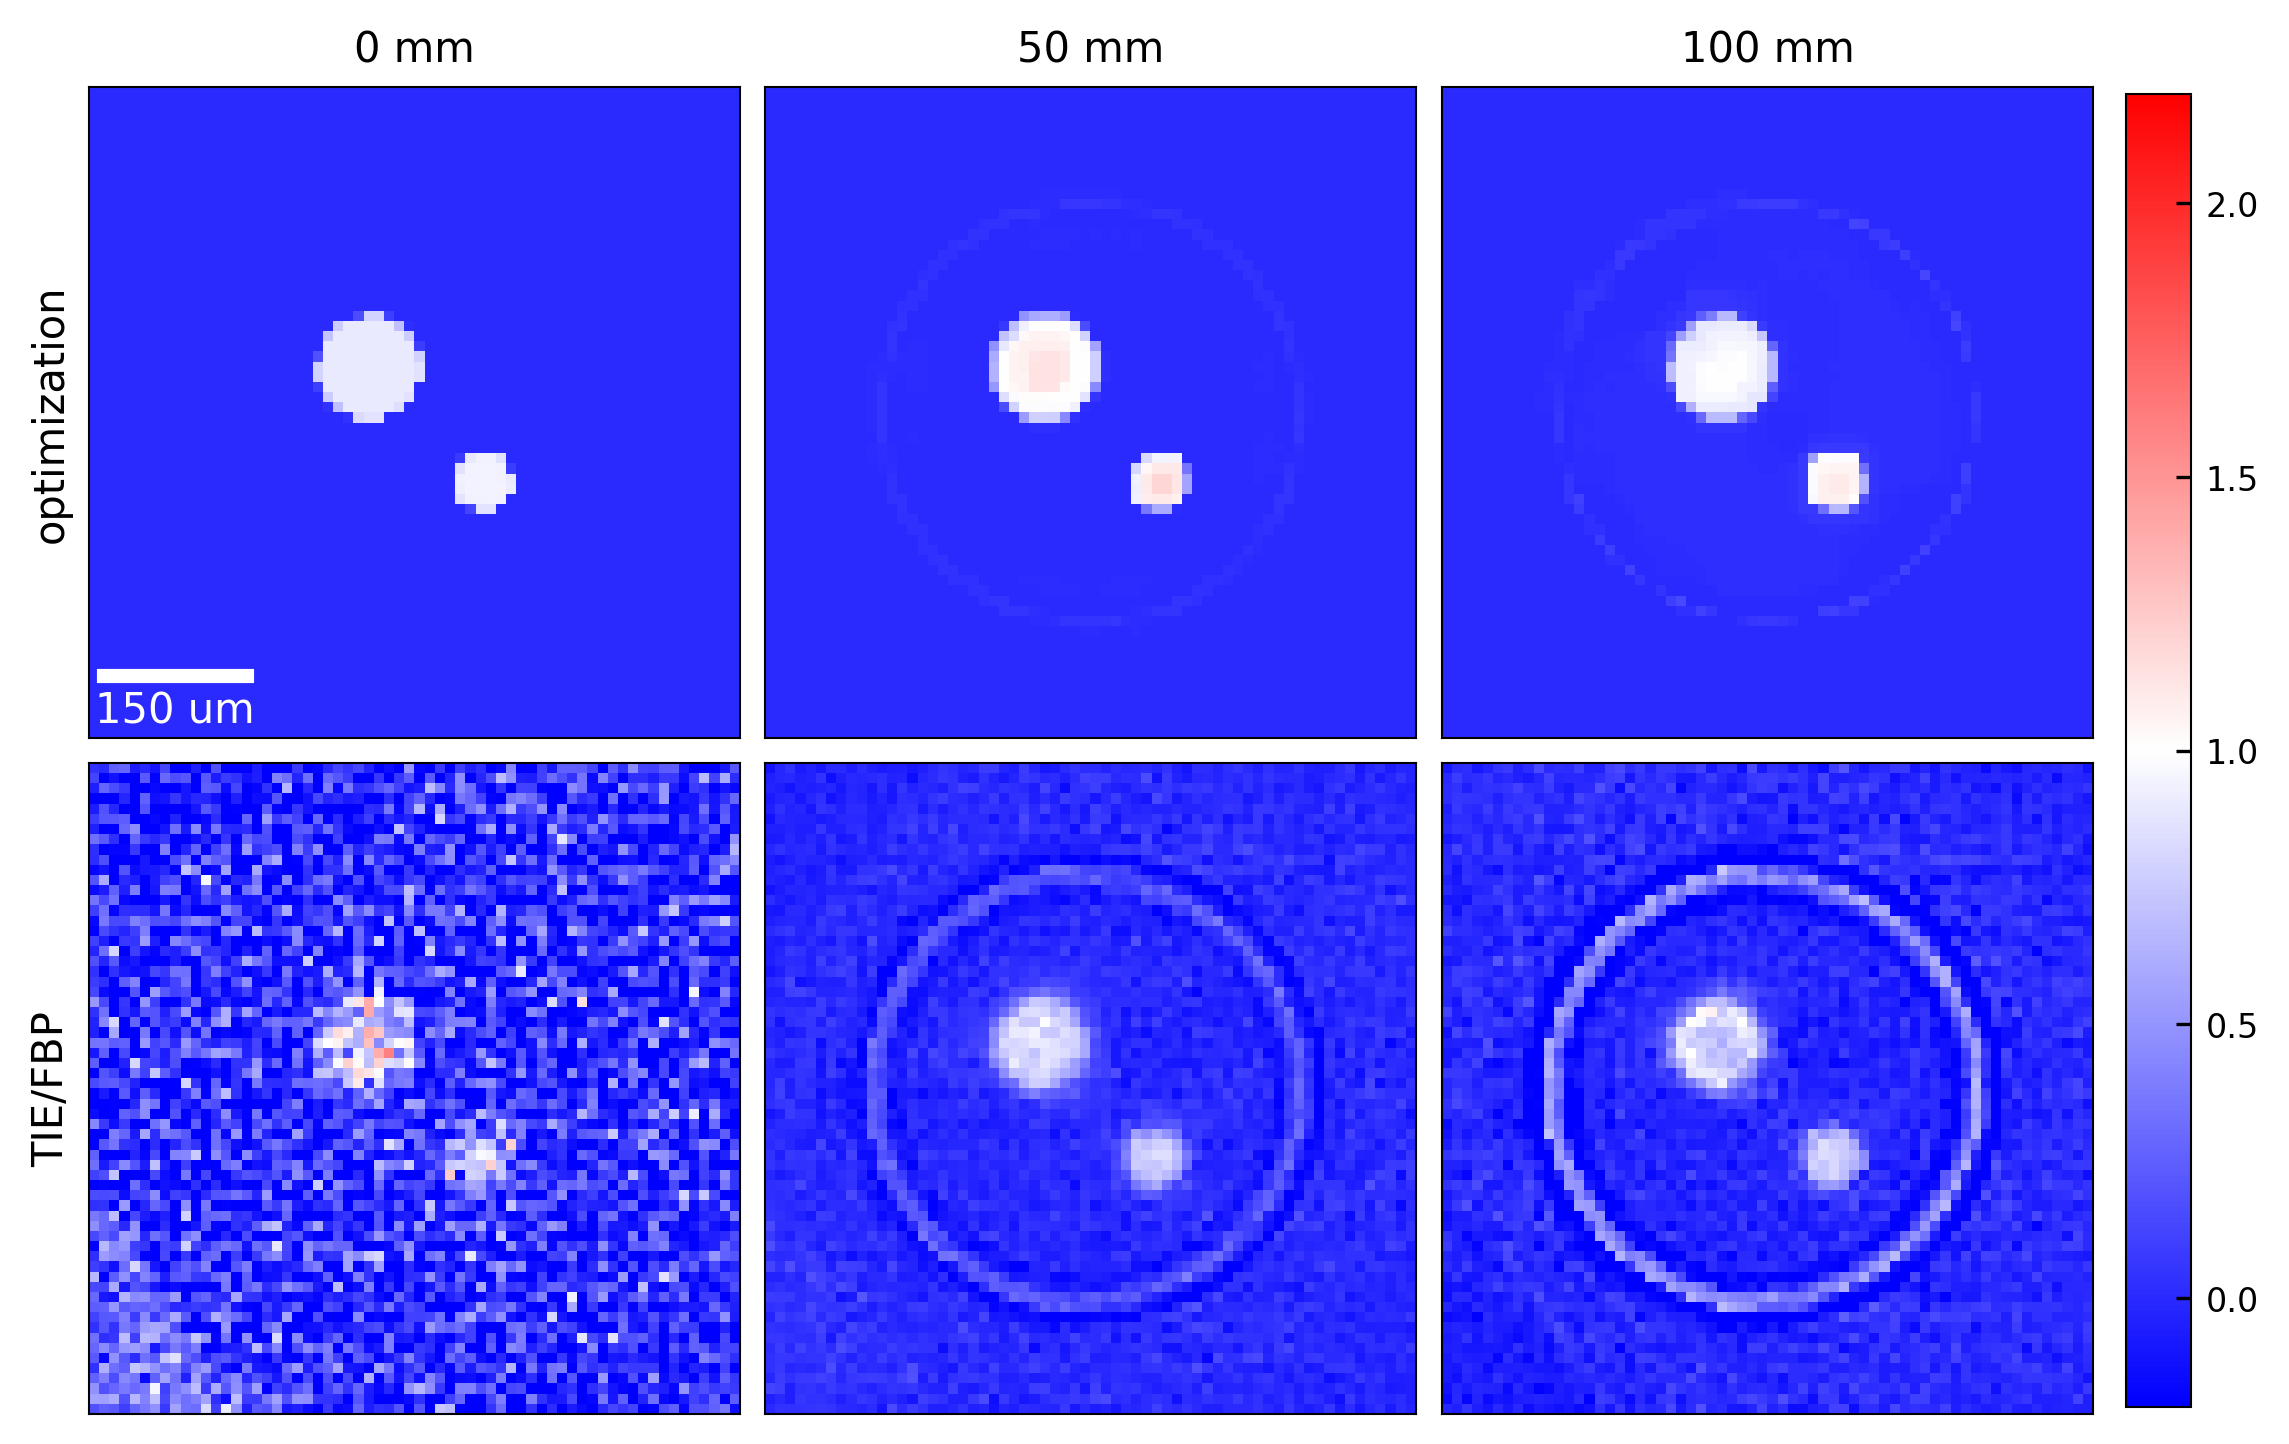

In [8]:
kw = {'cmap':'bwr', 'vmin':-0.2, 'vmax':2.2}

for imat in range(2):
    im_truth = phantom[:,lvl,:,imat] / densities[imat]

    fig, ax = plt.subplots(2, 3, figsize=[7.5,4.7], dpi=300, layout='constrained')
    ax[0,0].set_ylabel(f'optimization', fontsize=10)
    ax[1,0].set_ylabel(f'TIE/FBP', fontsize=10)
    
    for j, propdist in enumerate(propdists):
        ax[0,j].set_title(f'{propdist:.0f} mm')
        
        img_opt = loadfile(f'vol_{best_iters[j]:04}.bin', vol_shape, cwd=outd_main+f'{propdist:03}mm/')[:,lvl,:,imat]
        m = ax[0,j].imshow(img_opt / densities[imat], **kw)
        
        img_tie = loadfile('vol_tie.bin', vol_shape, cwd=outd_main+f'{propdist:03}mm/')[:,lvl,:,imat]
        m = ax[1,j].imshow(img_tie / densities[imat], **kw)
    
        for i in range(2):
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
    add_scalebar(ax[0,0])
    fig.colorbar(m, ax=ax[:,2], shrink=0.99)

    plt.savefig(figd+f'mat{imat+1}.pdf')
    plt.show()

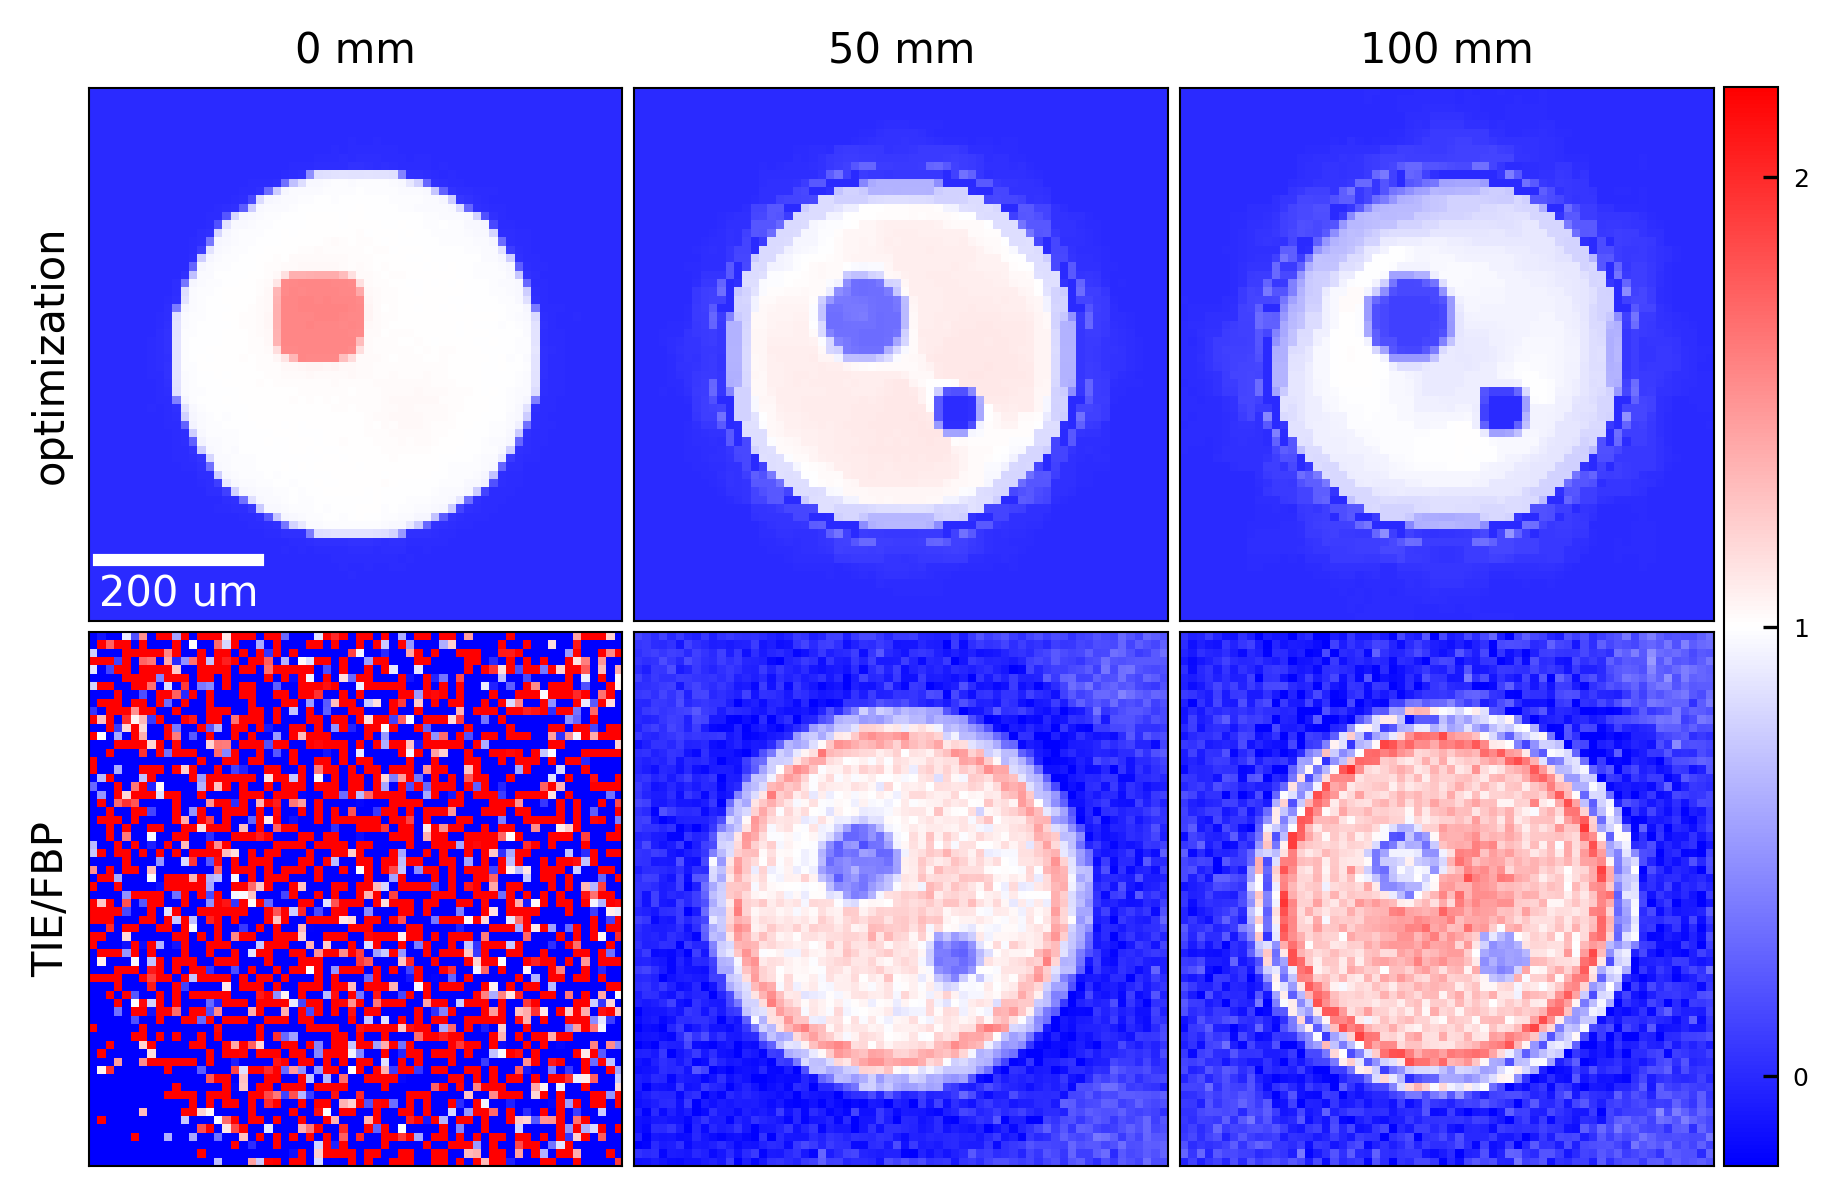

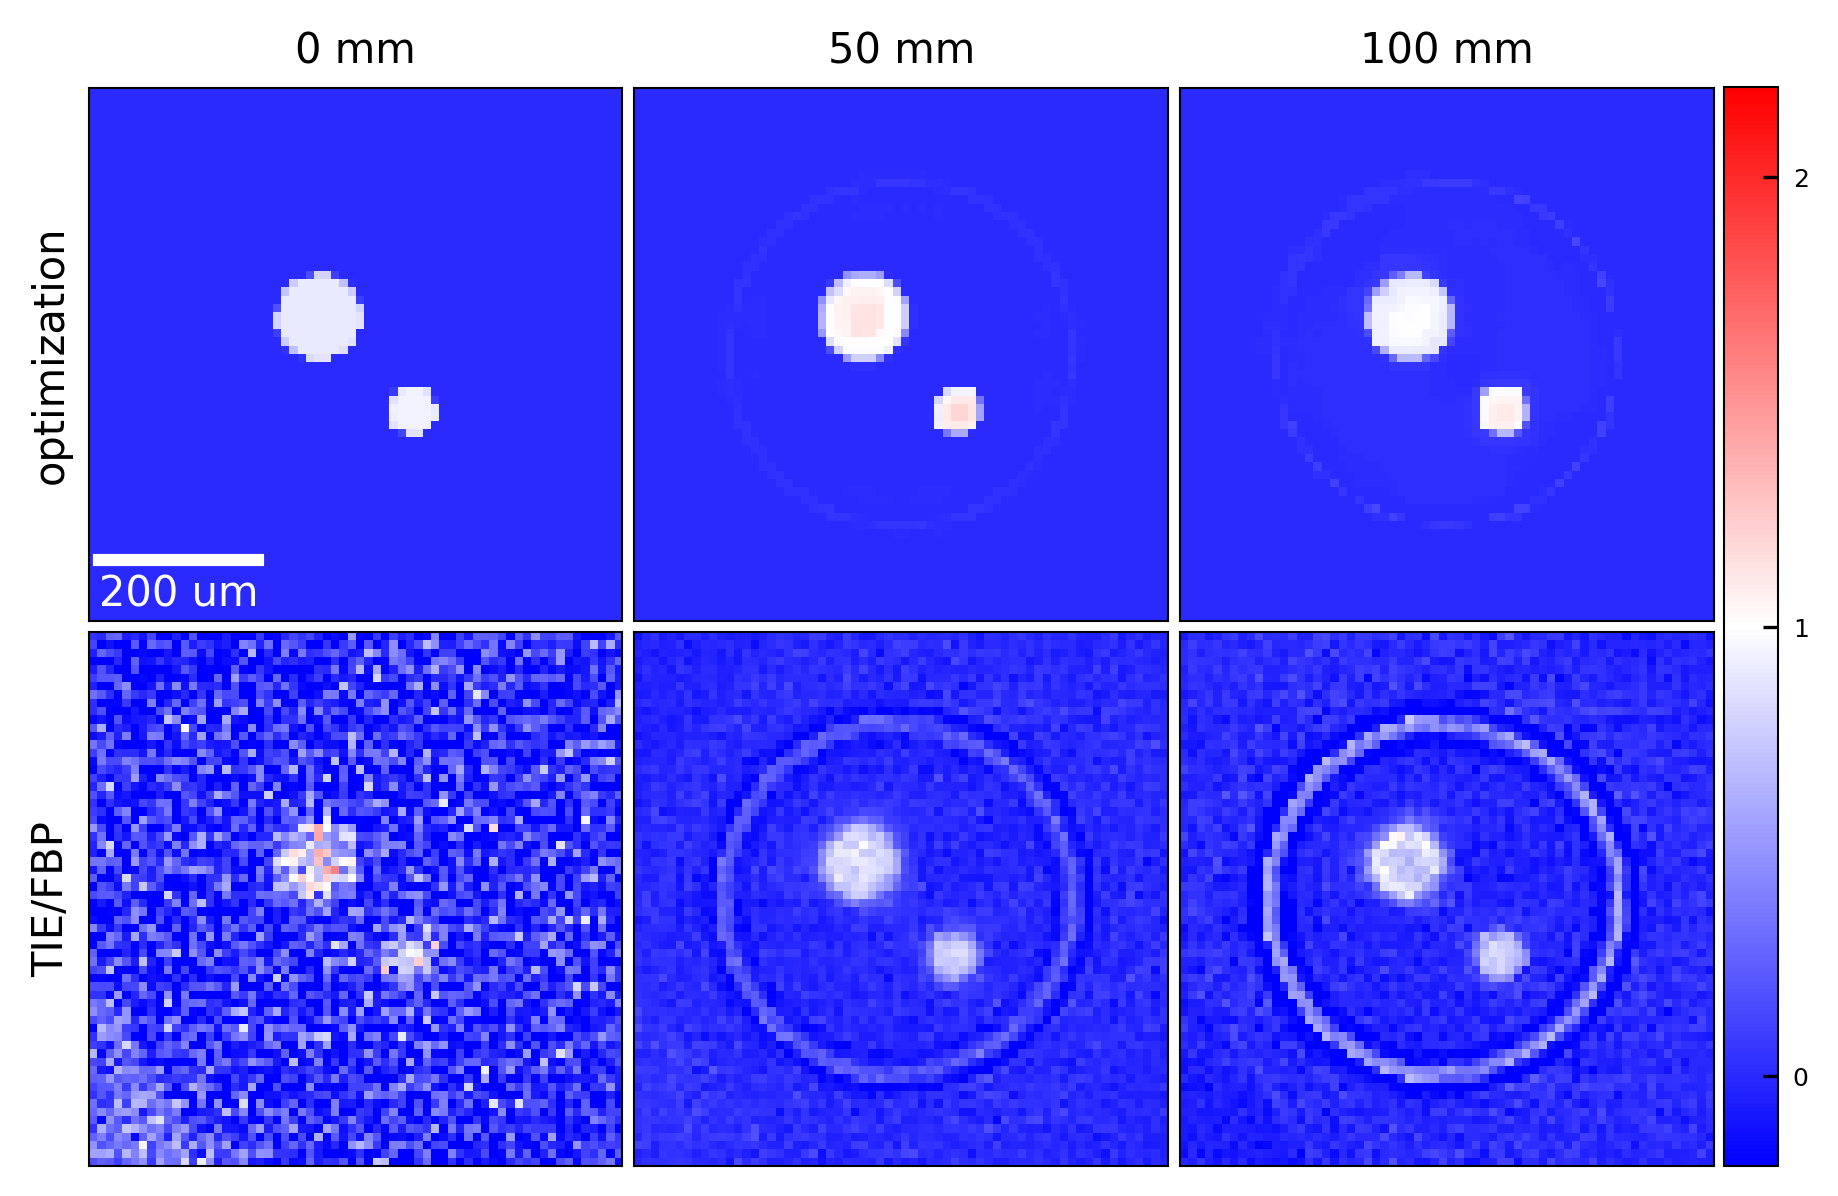

In [111]:
kw = {'cmap':'bwr', 'vmin':-0.2, 'vmax':2.2}

for imat in range(2):
    im_truth = phantom[:,lvl,:,imat] / densities[imat]

    fig, ax = plt.subplots(2, 3, figsize=[5.93,3.8], dpi=300, layout='constrained')
    ax[0,0].set_ylabel(f'optimization', fontsize=10)
    ax[1,0].set_ylabel(f'TIE/FBP', fontsize=10)
    
    for j, propdist in enumerate(propdists):
        ax[0,j].set_title(f'{propdist:.0f} mm')
        
        img_opt = loadfile(f'vol_{best_iters[j]:04}.bin', vol_shape, cwd=outd_main+f'{propdist:03}mm/')[:,lvl,:,imat]
        m = ax[0,j].imshow(img_opt / densities[imat], **kw)
        
        img_tie = loadfile('vol_tie.bin', vol_shape, cwd=outd_main+f'{propdist:03}mm/')[:,lvl,:,imat]
        m = ax[1,j].imshow(img_tie / densities[imat], **kw)
    
        for i in range(2):
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
    add_scalebar(ax[0,0])
    
    cbar = fig.colorbar(m, ax=ax[:,2], pad=0.02, shrink=0.996,  ticks=np.arange(0,2.1,1))
    cbar.ax.tick_params(labelsize=6) 
    fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=.01, wspace=.02)
    plt.savefig(figd+f'mat{imat+1}_tight.pdf')
    plt.show()
